<a href="https://colab.research.google.com/github/dkalenov/ML-Stock-Crypto-Trading/blob/4_trading/ML_Trading_Bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run

## Imports

In [1]:
! pip install ccxt
! pip install mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.7/288.7 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.9 MB/s eta 0:00:00


In [2]:
# Install build tools
!apt-get update
!apt-get install -y build-essential

# Download the TA-Lib source code
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz

# Extract the tarball
!tar -xzvf ta-lib-0.4.0-src.tar.gz

# Change directory to the extracted source code folder
%cd ta-lib/

# Configure the installation
!./configure --prefix=/usr

# Compile the source code
!make

# Install the compiled library
!make install

# Install the Python wrapper for TA-Lib
!pip install TA-Lib

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,550 kB]
Get:14 https://r2u.stat.illinois.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import ccxt
import talib
import random
import datetime
import time
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

## Funcrions

In [4]:
# get the data from MEXC (lines limit)
def get_mexc_data(symbol, timeframe, since, until):
  mexc = ccxt.mexc()
  all_ohlcv = []
  current_since = since

  while current_since < until:
    ohlcv = mexc.fetch_ohlcv(symbol, timeframe, since=current_since)
    if not ohlcv:
      break
    all_ohlcv.extend(ohlcv)
    current_since = ohlcv[-1][0] + 1 # update 'current_since' for next request
    time.sleep(mexc.rateLimit / 1000) # take into account the exchange request speed limit

  df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
  df.set_index('timestamp', inplace=True)
  return df

# Setting the time interval manually
start_date = datetime.datetime(2022, 9, 1) # Start date(year, month, day)
end_date = datetime.datetime(2024, 7, 26) # End date(year, month, day)

# Convert date to milliseconds
since = int(start_date.timestamp() * 1000)
until = int(end_date.timestamp() * 1000)

## Data extraction

In [5]:
# Data extraction
symbol = 'SOL/USDT' # SOL
timeframe = '1h'
data = get_mexc_data(symbol, timeframe, since, until)

In [6]:
data

,open,high,low,close,volume
timestamp,,,,,
2022-09-01 00:00:00,31.4975,31.7648,31.1539,31.4712,28546.04
2022-09-01 01:00:00,31.4712,31.6354,31.3671,31.5233,13224.38
2022-09-01 02:00:00,31.5233,31.7124,31.3485,31.4081,19282.40
2022-09-01 03:00:00,31.4081,31.5143,30.9804,31.2205,9224.64
2022-09-01 04:00:00,31.2205,31.4198,31.1368,31.3409,8926.01
...,...,...,...,...,...
2024-07-26 12:00:00,178.7200,179.4400,177.8700,178.2000,11411.46
2024-07-26 13:00:00,178.2000,184.0000,177.5000,182.7400,28549.98
2024-07-26 14:00:00,182.7400,183.1600,179.1700,180.9800,41345.09


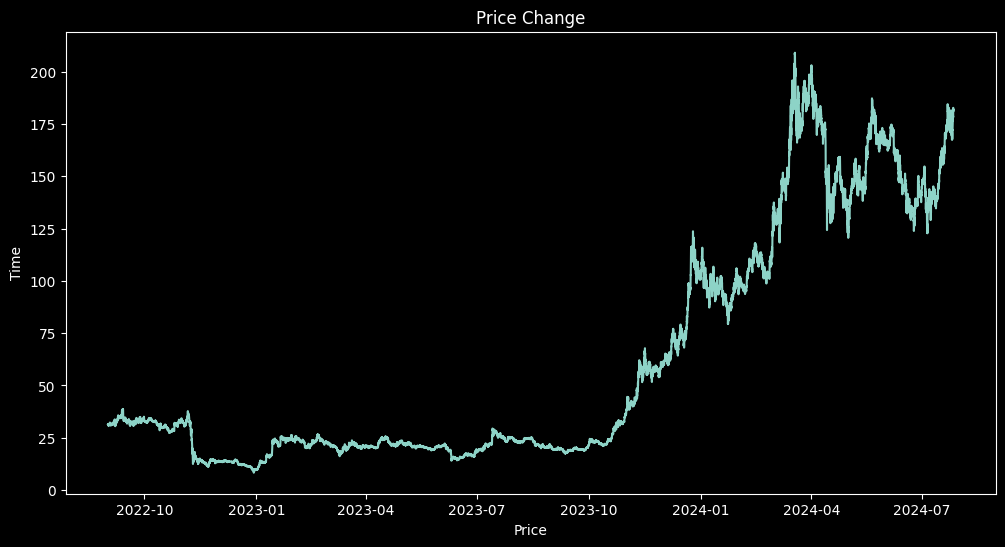

In [7]:
plt.style.use('dark_background')
flg, ax = plt.subplots(figsize=(12,6))
plt.plot(data.index, data['close'])
plt.xlabel('Price')
plt.ylabel('Time')
plt.title('Price Change')
plt.show()

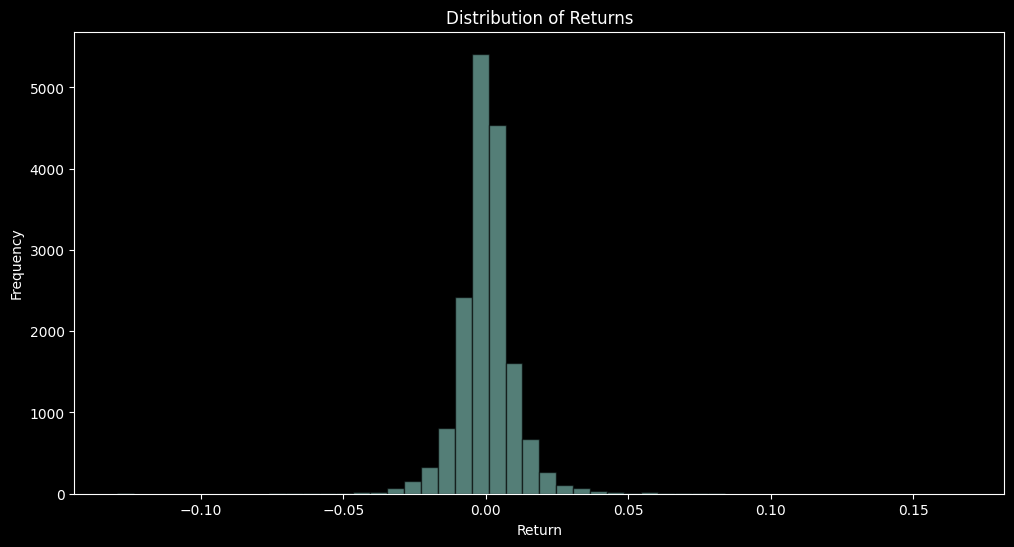

In [8]:
# simple yield calculation
data['return'] = data['close'].pct_change().shift(-1)

fig, ax = plt.subplots(figsize=(12,6))
plt.hist(data['return'], bins=50, edgecolor='black', alpha=0.6)
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.title('Distribution of Returns')
plt.show()

Based on the graph, we can judge that the profitability has a normal distribution.

## Percentage price change algorithm

If the price per hour increases by half a percent, then put the mark 1, otherwise mark 0

In [9]:
precentage_chage = 0.005 # 0.5%

# set the mark
data['price_change'] = data['close'].pct_change() # percentage price change
data['binary_target'] = np.where(data['price_change'].shift(-1) > precentage_chage, 1, 0)

In [10]:
# check and remove duplicates in index
data = data[~data.index.duplicated(keep='first')]

In [11]:
# indecators culculations
data['SMA_10'] = talib.SMA(data['close'], timeperiod=10)
data['EMA_10'] = talib.EMA(data['close'], timeperiod=10)
data['RSI_14'] = talib.RSI(data['close'], timeperiod=14)
data['MACD'], data['MACD_signal'], _ = talib.MACD(data['close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['bollinger_high'], data['bollinger_mid'], data['bollinger_low'] = talib.BBANDS(data['close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

In [12]:
# functions for calculating patterns
import pandas as pd

def is_doji(row, threshold=0.1):
    return abs(row['open'] - row['close']) <= threshold

def is_hammer(row):
    body = abs(row['open'] - row['close'])
    lower_shadow = row['open'] - row['low'] if row['open'] <  row['close'] else row['close'] - row['low']
    upper_shadow = row['high'] - row['close'] if row['open'] <  row['close'] else row['high'] - row['open']
    return lower_shadow > 2 * body and upper_shadow < body

def is_bullish_engulfing(current_row, previous_row):
    return previous_row['close'] < previous_row['open'] and current_row['close'] > current_row['open'] and \
           current_row['open'] < previous_row['close'] and current_row['close'] > previous_row['open']

def is_piercing_line(current_row, previous_row):
    return previous_row['close'] < previous_row['open'] and current_row['close'] > current_row['open'] and \
            current_row['open'] < previous_row['low'] and current_row['close'] > (previous_row['open'] + previous_row['close']) / 2

def is_morning_star(current_row, previous_row, pre_previous_row):
    return pre_previous_row['close'] < pre_previous_row['open'] and \
          abs(previous_row['close'] - previous_row['open']) < abs(pre_previous_row['close'] - pre_previous_row['open']) / 2 and \
          current_row['close'] > current_row['open'] and \
          current_row['open'] < previous_row['close'] and \
          current_row['close'] > (previous_row['close'] + previous_row['open']) / 2

def is_inverted_hammer(row):
    body = abs(row['open'] - row['close'])
    upper_shadow = row['high'] - row['close'] if row['open'] <  row['close'] else row['high'] - row['open']
    lower_shadow = row['open'] - row['low'] if row['open'] <  row['close'] else row['close'] - row['low']
    return upper_shadow > 2 * body and lower_shadow < body

def is_three_white_soldiers(df, idx):
    if idx < 2:
        return False
    current = df.iloc[idx]
    prev1 = df.iloc[idx - 1]
    prev2 = df.iloc[idx - 2]
    return all([current['close'] > current['open'], prev1['close'] > prev1['open'], prev2['close'] > prev2['open']]) and \
           all([current['open'] > prev1['close'], prev1['open'] > prev2['close']]) and \
           all([current['close'] > prev1['close'], prev1['close'] > prev2['close']])

def is_harami_cross(current_row, previous_row):
    return abs(current_row['open'] - current_row['close']) < (current_row['high'] - current_row['low']) * 0.1 and \
           previous_row['open'] > previous_row['close'] and current_row['high'] < previous_row['open' ] and current_row['low'] > previous_row['close']

data['doji'] = data.apply(is_doji, axis=1)
data['hammer'] = data.apply(is_hammer, axis=1)
data['bull_engulfing'] = data.apply(lambda row: is_bullish_engulfing(row, data.iloc[data.index.get_loc(row.name) - 1]) if data.index.get_loc(row.name) > 0 else False, axis=1)
data['piercing_line'] = data.apply(lambda row: is_piercing_line(row, data.iloc[data.index.get_loc(row.name) - 1]) if data.index.get_loc(row.name) > 0 else False, axis=1)
data['morning_star'] = data.apply(lambda row: is_morning_star(row, data.iloc[data.index.get_loc(row.name) - 1], data.iloc[data.index.get_loc(row.name) - 2]) if data.index.get_loc(row.name) > 1 else False, axis=1)
data['inverted_hammer'] = data.apply(is_inverted_hammer, axis=1)
data['three_white_soldiers'] = data.apply(lambda row: is_three_white_soldiers(data, data.index.get_loc(row.name)), axis=1)
data['harami_cross'] = data.apply(lambda row: is_harami_cross(row, data.iloc[data.index.get_loc(row.name) - 1]) if data.index.get_loc(row.name) > 0 else False, axis=1)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16673 entries, 2022-09-01 00:00:00 to 2024-07-26 16:00:00
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   open                  16673 non-null  float64
 1   high                  16673 non-null  float64
 2   low                   16673 non-null  float64
 3   close                 16673 non-null  float64
 4   volume                16673 non-null  float64
 5   return                16672 non-null  float64
 6   price_change          16672 non-null  float64
 7   binary_target         16673 non-null  int64  
 8   SMA_10                16664 non-null  float64
 9   EMA_10                16664 non-null  float64
 10  RSI_14                16659 non-null  float64
 11  MACD                  16640 non-null  float64
 12  MACD_signal           16640 non-null  float64
 13  bollinger_high        16654 non-null  float64
 14  bollinger_mid         16654 non-nul

In [14]:
data.head(3)

,open,high,low,close,volume,return,price_change,binary_target,SMA_10,EMA_10,...,bollinger_mid,bollinger_low,doji,hammer,bull_engulfing,piercing_line,morning_star,inverted_hammer,three_white_soldiers,harami_cross
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-09-01 00:00:00,31.4975,31.7648,31.1539,31.4712,28546.04,0.001655,NaN,0,NaN,NaN,...,NaN,NaN,True,False,False,False,False,False,False,False
2022-09-01 01:00:00,31.4712,31.6354,31.3671,31.5233,13224.38,-0.003654,0.001655,0,NaN,NaN,...,NaN,NaN,True,False,False,False,False,False,False,False
2022-09-01 02:00:00,31.5233,31.7124,31.3485,31.4081,19282.40,-0.005973,-0.003654,0,NaN,NaN,...,NaN,NaN,False,False,False,False,False,False,False,False


In [15]:
data['ATR'] = talib.ATR(data['high'], data['low'], data['close'], timeperiod=14)

#data['historical_volatility'] = talib.NATR(data['high'], data['low'], data['close'], timeperiod=14)
data['historical_volatility'] = data['close'].pct_change().rolling(window=14).std() * np.sqrt(252)

data['volume_mean_10'] = data['volume'].rolling(window=10).mean()
data['volume_mean_30'] = data['volume'].rolling(window=30).mean()

data['parabolic_SAR'] = talib.SAR(data['high'], data['low'], acceleration=0.02, maximum=0.2)
data['ADX'] = talib.ADX(data['high'], data['low'], data['close'], timeperiod=14)

data['stochastic_oscillator_k'], data['stochastic_oscillator_d'] = talib.STOCH(data['high'], data['low'], data['close'],
                                                                               fastk_period=14, slowk_period=3, slowk_matype=0,
                                                                               slowd_period=3, slowd_matype=0)

data['CCI'] = talib.CCI(data['high'], data['low'], data['close'], timeperiod=14)

data['SMA_50'] = talib.SMA(data['close'], timeperiod=50)
data['SMA_200'] = talib.SMA(data['close'], timeperiod=200)
data['EMA_50'] = talib.EMA(data['close'], timeperiod=50)
data['EMA_200'] = talib.EMA(data['close'], timeperiod=200)

# Removing rows with NaN values
data.dropna(inplace=True)
data.head()

,open,high,low,close,volume,return,price_change,binary_target,SMA_10,EMA_10,...,volume_mean_30,parabolic_SAR,ADX,stochastic_oscillator_k,stochastic_oscillator_d,CCI,SMA_50,SMA_200,EMA_50,EMA_200
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-09-09 07:00:00,35.3123,35.3859,35.0533,35.3479,24681.91,0.008532,0.001008,1,34.52294,34.659970,...,27992.206333,33.854624,41.631243,92.488749,93.121410,113.885058,32.807284,31.892516,33.206264,31.892516
2022-09-09 08:00:00,35.3479,35.9350,35.3134,35.6495,26617.94,-0.006306,0.008532,0,34.73737,34.839885,...,28775.598000,34.052741,43.937060,92.378440,92.615920,122.861881,32.898364,31.913407,33.302077,31.929898
2022-09-09 09:00:00,35.6495,35.6862,35.2138,35.4247,20650.58,0.008768,-0.006306,1,34.91817,34.946215,...,28185.419000,34.316257,45.661820,88.284768,91.050652,89.681071,32.985408,31.932914,33.385317,31.964673
2022-09-09 10:00:00,35.4247,35.7821,35.3318,35.7353,11412.67,-0.009548,0.008768,0,35.07386,35.089685,...,28251.421333,34.542881,47.339952,87.731830,89.465013,91.268893,33.074624,31.954550,33.477473,32.002191
2022-09-09 11:00:00,35.7353,35.7353,35.1280,35.3941,44464.51,-0.003972,-0.009548,0,35.20413,35.145033,...,29579.585333,34.737778,48.035765,83.907114,86.641237,63.943813,33.157728,31.975418,33.552635,32.035942


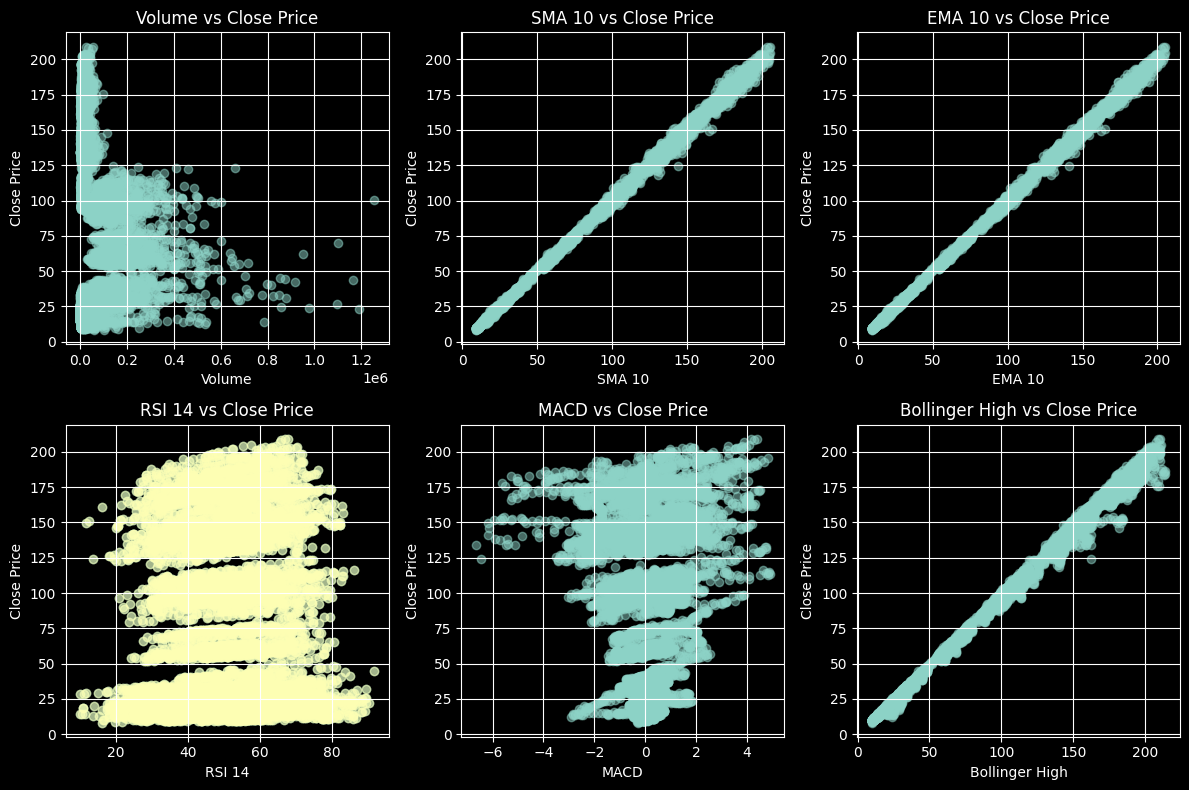

In [16]:
# Visualizing indicators
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))


# Scatter plot: Close price vs volume
axes[0, 0].scatter(data['volume'], data['close'], alpha=0.5)
axes[0, 0].set_xlabel('Volume')
axes[0, 0].set_ylabel('Close Price')
axes[0, 0].set_title('Volume vs Close Price')
axes[0, 0].grid(True)

# Scatter plot: Close price vs SMA 10
axes[0, 1].scatter(data['SMA_10'], data['close'], alpha=0.5)
axes[0, 1].set_xlabel('SMA 10')
axes[0, 1].set_ylabel('Close Price')
axes[0, 1].set_title('SMA 10 vs Close Price')
axes[0, 1].grid(True)

# Scatter plot: Close price vs EMA 10
axes[0, 2].scatter(data['EMA_10'], data['close'], alpha=0.5)
axes[0, 2].set_xlabel('EMA 10')
axes[0, 2].set_ylabel('Close Price')
axes[0, 2].set_title('EMA 10 vs Close Price')
axes[0, 2].grid(True)

# Scatter plot: Close price vs RSI 14
axes[1, 0].scatter(data['RSI_14'], data['close'], alpha=0.5)
axes[1, 0].set_xlabel('RSI 14')
axes[1, 0].set_ylabel('Close Price')
axes[1, 0].set_title('RSI 14 vs Close Price')
axes[1, 0].grid(True)

# Scatter plot: Close price vs RSI 14x
axes[1, 0].scatter(data['RSI_14'], data['close'], alpha=0.5)
axes[1, 0].set_xlabel('RSI 14')
axes[1, 0].set_ylabel('Close Price')
axes[1, 0].set_title('RSI 14 vs Close Price')
axes[1, 0].grid(True)

# Scatter plot: Close price vs MACD
axes[1, 1].scatter(data['MACD'], data['close'], alpha=0.5)
axes[1, 1].set_xlabel('MACD')
axes[1, 1].set_ylabel('Close Price')
axes[1, 1].set_title('MACD vs Close Price')
axes[1, 1].grid(True)

# Scatter plot: Close price vs Bollinger High bollinger_high
axes[1, 2].scatter(data['bollinger_high'], data['close'], alpha=0.5)
axes[1, 2].set_xlabel('Bollinger High')
axes[1, 2].set_ylabel('Close Price')
axes[1, 2].set_title('Bollinger High vs Close Price')
axes[1, 2].grid(True)


plt.tight_layout()
plt.show()

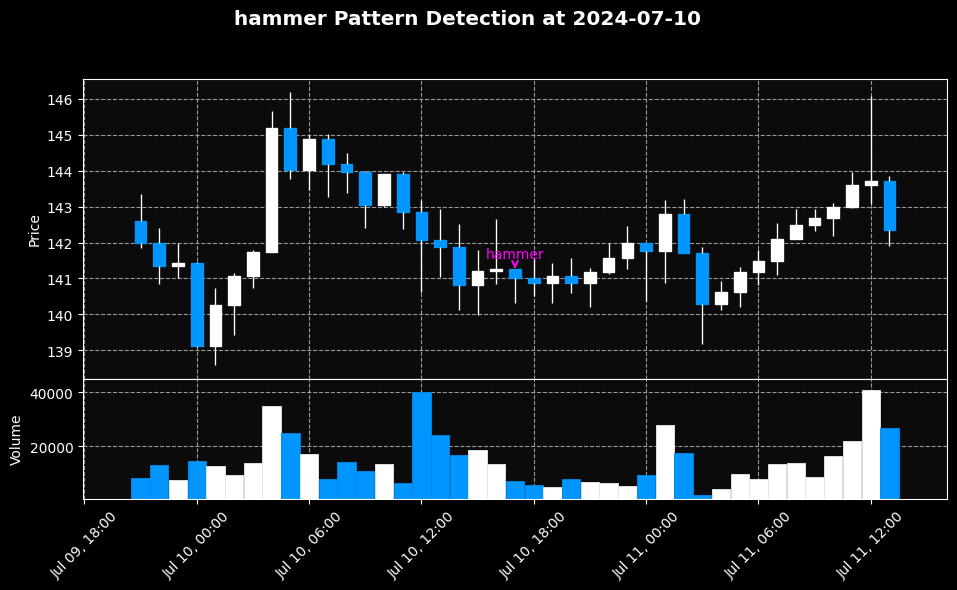

In [17]:
from ast import pattern
# Function for analyzing candlestick patterns

def plot_random_pattern(data, pattern_column, pattern_name):
    patterns = data[data[pattern_column] != 0]

    if patterns.empty:
      print(f"No occurences of {pattern_name} pattern found.")
      return

    random_index = random.choice(patterns.index)
    start_index = max(0, data.index.get_loc(random_index) - 20)
    end_index = min(len(data), data.index.get_loc(random_index) + 20)

    data_window = data.iloc[start_index:end_index+1]

    fig, axlist = mpf.plot(data_window, type='candle', style='nightclouds', volume=True,
                          title=f'{pattern_name} Pattern Detection at {random_index.date()}',
                          show_nontrading=True, returnfig=True, figsize=(12,6))

    axes = axlist[0]
    pattern_row = data.loc[random_index]

    # Add a short line to a candlestick plot
    axes.annotate('', xy=(random_index, pattern_row['high']),
                  xytext=(random_index, pattern_row['high'] + 0.15), # set the line size
                  arrowprops=dict(facecolor='magenta', edgecolor='magenta', arrowstyle='->', lw=1.5))

    axes.text(random_index, pattern_row['high'] + 0.2, pattern_name,
              horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='magenta')


# display a random pattern
plot_random_pattern(data, 'hammer', 'hammer')

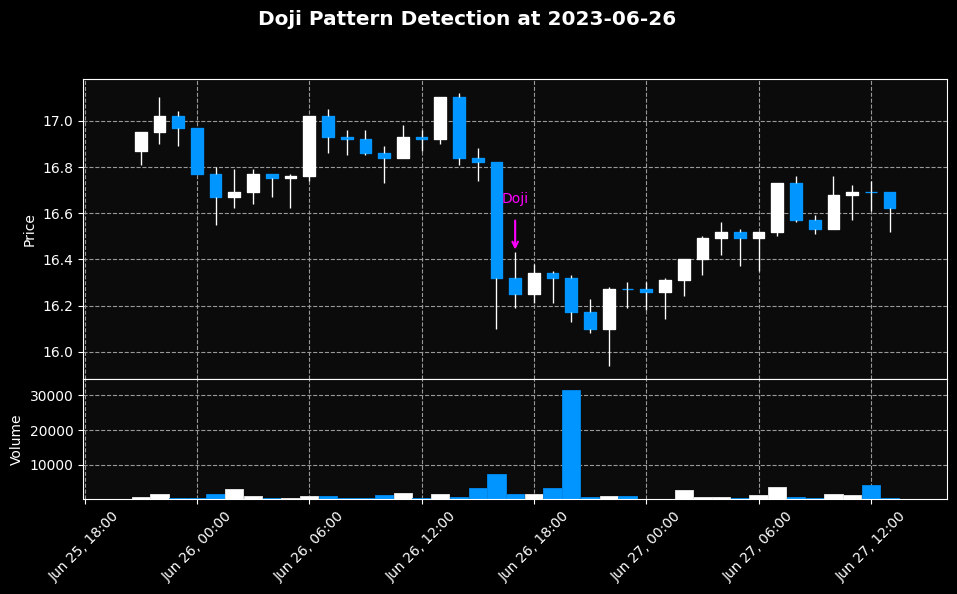

In [18]:
plot_random_pattern(data, 'doji', 'Doji')

In [19]:
plot_random_pattern(data, 'harami_cross', 'harami_cross')

No occurences of harami_cross pattern found.


In [20]:
plot_random_pattern(data, 'three_white_soldiers', 'three_white_soldiers')

No occurences of three_white_soldiers pattern found.


In [21]:
plot_random_pattern(data, 'morning_star', 'morning_star')

No occurences of morning_star pattern found.


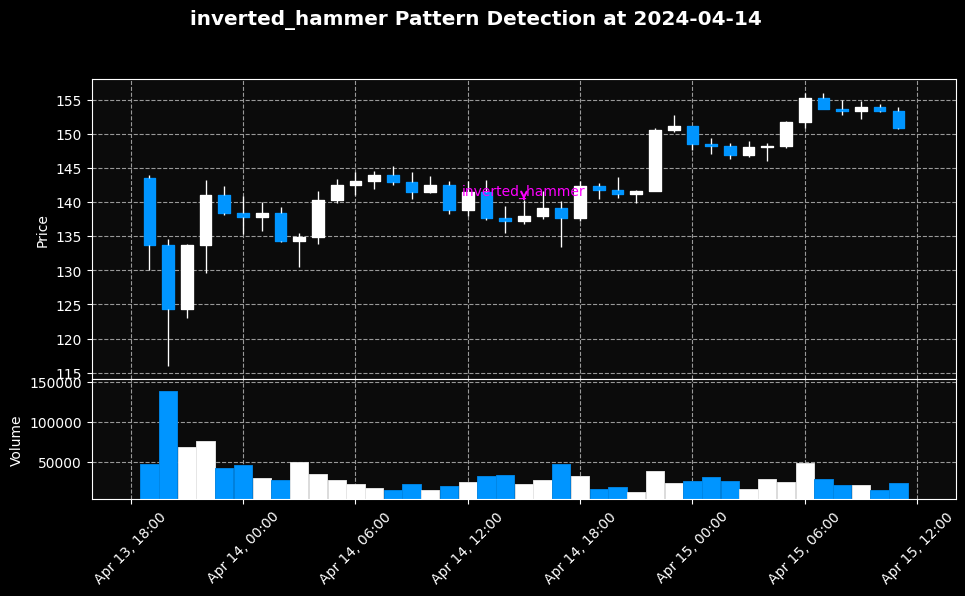

In [22]:
plot_random_pattern(data, 'inverted_hammer', 'inverted_hammer')

In [23]:
plot_random_pattern(data, 'piercing_line', 'piercing_line')

No occurences of piercing_line pattern found.


## Data splitting

In [24]:
data.columns

Index(['open', 'high', 'low', 'close', 'volume', 'return', 'price_change',
       'binary_target', 'SMA_10', 'EMA_10', 'RSI_14', 'MACD', 'MACD_signal',
       'bollinger_high', 'bollinger_mid', 'bollinger_low', 'doji', 'hammer',
       'bull_engulfing', 'piercing_line', 'morning_star', 'inverted_hammer',
       'three_white_soldiers', 'harami_cross', 'ATR', 'historical_volatility',
       'volume_mean_10', 'volume_mean_30', 'parabolic_SAR', 'ADX',
       'stochastic_oscillator_k', 'stochastic_oscillator_d', 'CCI', 'SMA_50',
       'SMA_200', 'EMA_50', 'EMA_200'],
      dtype='object')

In [25]:
features = ['SMA_10', 'EMA_10', 'RSI_14', 'MACD', 'MACD_signal',
       'bollinger_high', 'bollinger_mid', 'bollinger_low', 'doji', 'hammer',
       'bull_engulfing', 'piercing_line', 'morning_star', 'inverted_hammer',
       'three_white_soldiers', 'harami_cross', 'ATR', 'historical_volatility',
       'volume_mean_10', 'volume_mean_30', 'parabolic_SAR', 'ADX',
       'stochastic_oscillator_k', 'stochastic_oscillator_d', 'CCI', 'SMA_50',
       'SMA_200', 'EMA_50', 'EMA_200']

X = data[features]
y = data['binary_target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

## Train and evaluation

In [26]:

import xgboost as xgb
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]


In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from tabulate import tabulate

# Calculate the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| Accuracy  | 0.680425 |
+-----------+----------+
| Precision | 0.265267 |
+-----------+----------+
| Recall    | 0.172243 |
+-----------+----------+
| F1        | 0.208866 |
+-----------+----------+
| ROC AUC   | 0.527646 |
+-----------+----------+


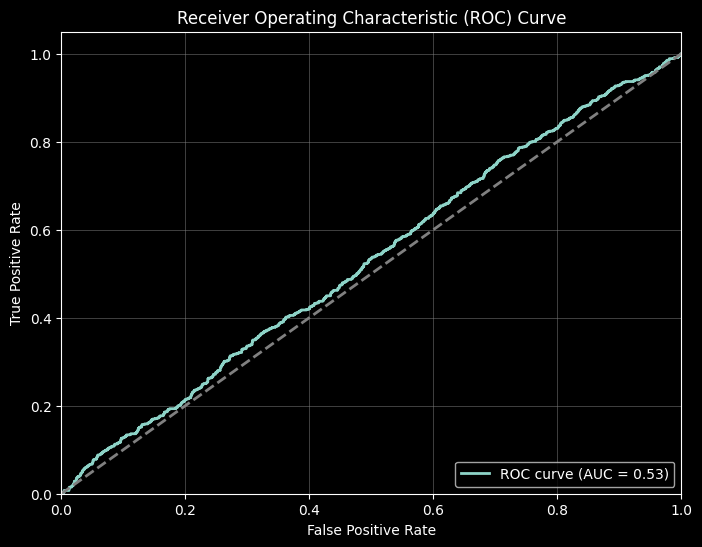


Confusion Matrix:
+-----------------+----------------------+----------------------+
|                 |   Predicted Negative |   Predicted Positive |
+=================+======================+======================+
| Actual Negative |                 2103 |                  385 |
+-----------------+----------------------+----------------------+
| Actual Positive |                  668 |                  139 |
+-----------------+----------------------+----------------------+


In [28]:
metrics_table = [
    ['Accuracy', accuracy],
    ['Precision', precision],
    ['Recall', recall],
    ['F1', f1],
    ['ROC AUC', roc_auc]
]

print(tabulate(metrics_table, headers=['Metric', 'Value'], tablefmt='grid'))

# ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.7)
plt.legend(loc="lower right")
plt.show()

# Confusion matrix
conf_matrix_table = [['', 'Predicted Negative', 'Predicted Positive'],
                     ['Actual Negative', conf_matrix[0][0], conf_matrix[0][1]],
                     ['Actual Positive', conf_matrix[1][0], conf_matrix[1][1]]
                     ]

print('\nConfusion Matrix:')
print(tabulate(conf_matrix_table, headers='firstrow', tablefmt='grid'))

## Backtest

In [29]:
! pip install backtrader
import backtrader as bt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 19.3 MB/s eta 0:00:00


In [30]:
# Creating a Dataframe with test data and predictions

test_data = data.loc[X_test.index].copy()
test_data['predictions'] = y_pred

# Converting data to backtrader format
class CustomPandasData(bt.feeds.PandasData):
    lines = ('predictions',)
    params = (
        ('predictions', -1),
        ('datetime', None),
        ('open', 'open'),
        ('high', 'high'),
        ('low', 'low'),
        ('close', 'close'),
        ('volume', 'volume'),
        ('openinterest', None),
    )

In [31]:
class MLStrategy(bt.Strategy):
    params = (
        ('stop_loss', 0.01), # 1% stop loss
        ('take_profit', 0.1), # 10% take profit
        ('stake', 1000) # position size in dollars
    )

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.predictions = self.datas[0].predictions
        self.order = None # checking for existing order
        self.price = None
        self.stop_price = None
        self.take_profit_price = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return # orders sent / accepted by broker

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f"BUY EXECUTED, Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Comm: {order.executed.comm:.2f}")
                self.price = order.executed.price
                self.stop_price = self.price * (1.0 - self.params.stop_loss)
                self.take_profit_price = self.price * (1.0 + self.params.take_profit)
            elif order.issell():
                self.log(f"SELL EXECUTED, Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Comm: {order.executed.comm:.2f}")
            self.order = None

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION PROFIT, GROSS {trade.pnl:.2f}, NET {trade.pnlcomm:.2f}')

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} {txt}')

    def next(self):
        if self.order:
            return

        if not self.position:
            if self.predictions[0] > 0:
                self.order = self.buy(size=self.params.stake / self.dataclose[0])
                self.log(f'BUY CREATED, Price: {self.dataclose[0]:.2f}')

        else:
            if self.dataclose[0] <= self.stop_price or self.dataclose[0] >= self.take_profit_price:
                self.order = self.sell(size=self.position.size)
                self.log(f'SELL CREATED, Price: {self.dataclose[0]:.2f}')

        # Output current portfolio value for debugging
        self.log(f'Position Value: {self.broker.getvalue():.2f}')

In [32]:
# Create Cerebro and add data and strategy
cerebro = bt.Cerebro()
cerebro.addstrategy(MLStrategy)


# Convert data to backtrader format
datafeed = CustomPandasData(dataname=test_data)
cerebro.adddata(datafeed)

# Add Observer to track profile cost
cerebro.addobserver(bt.observers.Value)

# Initial funds
cerebro.broker.set_cash(10000.0)

# Set Commision
cerebro.broker.setcommission(commission=0.001)


# Run backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
strategies = cerebro.run()
print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Getting profile values ​​and dates from Observer
portfolio_values = [ob for ob in strategies[0].observers if isinstance(ob, bt.observers.Value)][0].lines.value.get(0, size=len(test_data))
portfolio_dates = test_data.index[:len(portfolio_values)]

Starting Portfolio Value: 10000.00
2024-03-11 Position Value: 10000.00
2024-03-11 Position Value: 10000.00
2024-03-11 Position Value: 10000.00
2024-03-11 Position Value: 10000.00
2024-03-11 Position Value: 10000.00
2024-03-11 Position Value: 10000.00
2024-03-11 Position Value: 10000.00
2024-03-11 Position Value: 10000.00
2024-03-11 Position Value: 10000.00
2024-03-11 Position Value: 10000.00
2024-03-11 Position Value: 10000.00
2024-03-11 Position Value: 10000.00
2024-03-11 Position Value: 10000.00
2024-03-11 Position Value: 10000.00
2024-03-11 Position Value: 10000.00
2024-03-12 Position Value: 10000.00
2024-03-12 Position Value: 10000.00
2024-03-12 Position Value: 10000.00
2024-03-12 Position Value: 10000.00
2024-03-12 Position Value: 10000.00
2024-03-12 Position Value: 10000.00
2024-03-12 Position Value: 10000.00
2024-03-12 Position Value: 10000.00
2024-03-12 Position Value: 10000.00
2024-03-12 Position Value: 10000.00
2024-03-12 Position Value: 10000.00
2024-03-12 Position Value: 10

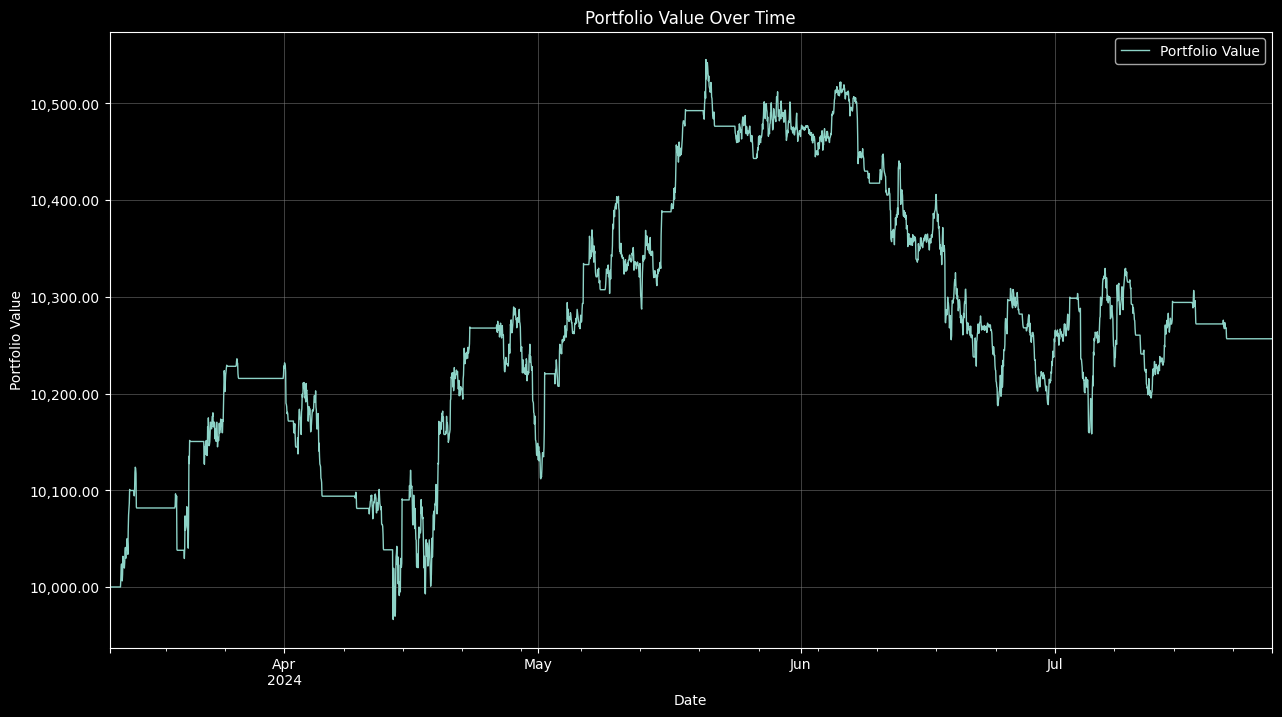

In [34]:
# Creating a Dataframe with portfolio values and predictions

portfolio_df = pd.DataFrame({'Date': portfolio_dates, 'portfolio_value': portfolio_values})
portfolio_df.set_index('Date', inplace=True)

%matplotlib inline
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(15, 8))
portfolio_df['portfolio_value'].plot(label='Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.7)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.2f}'.format(x)))
plt.legend()
plt.show()

## Log profobility

log_return = log(close t+1 / close t) - логорифм от часовой доходности 4:30